
Reproduzca el panel derecho  la Figura 2.9 de ISLR (solamente las curvas de test y training) utilizando los datos de fitting.txt y métodos MCMC para encontrar los mejor parámetros de los modelos polinomiales de grado cero hasta diez.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

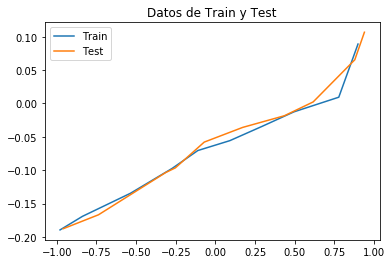

In [2]:
Data = np.loadtxt("fitting.txt")

# Convierto los datos en arrays
x_obs = np.array(Data[:,0])
y_obs = np.array(Data[:,1])
sigma_y_obs = np.array(Data[:,2])

# Los ordeno de menor a mayor
x_index = np.argsort(x_obs)
y_index = np.argsort(y_obs)
sigma_index = np.argsort(sigma_y_obs)

x_obs = x_obs[x_index]
y_obs = y_obs[y_index]
sigma_y_obs = sigma_y_obs[sigma_index]

# Divido los datos en train (pares) y test (impares)
x_train = x_obs[0::2]
y_train = y_obs[0::2]
sigma_y_train = sigma_y_obs[0::2]

x_test = x_obs[1::2]
y_test = y_obs[1::2]
sigma_y_test = sigma_y_obs[1::2]

# Plots. Los datos de train y test se deben parecer para que tenga sentido
plt.plot(x_train, y_train, label='Train')
plt.plot(x_test, y_test, label='Test')
plt.title('Datos de Train y Test')
plt.legend()

In [3]:
# Modelo. Para un polinomio de grado n_param
def model(x, param):
    n_param = len(param)
    y = 0
    for i in range(n_param):
        y += param[i] * x**i
    return y 

# Loglikelihood. Gaussiana
def loglikelihood(x_obs, y_obs, sigma_y_obs, param):
    y_mod = model(x_obs, param)
    d = -0.5*((y_mod - y_obs)/sigma_y_obs)**2
    norm = np.sqrt(2.0*np.pi*sigma_y_obs**2)
    return np.sum(d - np.log(norm))

# LogPrior. Elijo el intervalo donde seguro caen los parametros 
def logprior(param):
    p = 0.0
    n_param = len(param)
    for i in range(n_param):
        if param[i] < 50 and param[i]> -50:
            p += 0.0
        else:
            p += np.inf
    return p

def metropolis_hashtings(n_param):
    N = 50000
    l_param = [np.random.random(size=n_param)]
    sigma_param = np.random.random(size=n_param)
    for i in range(1,N):
        propuesta  = l_param[i-1] + np.random.normal(size=n_param)*sigma_param
        logposterior_viejo = loglikelihood(x_obs, y_obs, sigma_y_obs, l_param[i-1]) + logprior(l_param[i-1])
        logposterior_nuevo = loglikelihood(x_obs, y_obs, sigma_y_obs, propuesta) + logprior(propuesta)

        r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
        alpha = np.random.random()
        
        if(alpha<r):
            l_param.append(propuesta)
        else:
            l_param.append(l_param[i-1])

    l_param = np.array(l_param)
    # print(np.shape(l_param))

    best = np.zeros(n_param)
    for i in range(n_param):
        best[i] = np.mean(l_param[:,i])
    
    return best

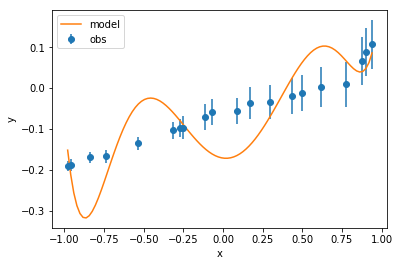

In [4]:
# Modelo de polinomio de grado n 
n = 10 

x_model = np.linspace(x_obs.min(), x_obs.max(), 100)
y_model = model(x_model, metropolis_hashtings(n))

plt.errorbar(x_obs,y_obs, yerr=sigma_y_obs, fmt='o', label='obs')
plt.plot(x_model, y_model, label='model')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig('best_model.pdf')

In [5]:
# Funcion para el MSE con n arbitrario
def mse(n, x_obs, y_obs):
    
    mse = np.zeros(n)
    for j in range(n):
        x_model = np.linspace(x_obs.min(), x_obs.max(), x_obs.shape[0])
        y_model = model(x_model, metropolis_hashtings(j))
        
        mse[j] = sum((y_obs-y_model)**2)/(y_obs.shape[0])
        
    return mse

Text(0,0.5,'Degree of Polynomial')

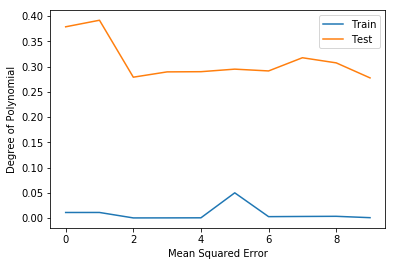

In [6]:
# Plots. MSE en funcion del Grado del Polinomio (como en el enunciado) Nose a que se refie el libro con Flexibility
flex_max = 10
flexibility = np.arange(0, flex_max, 1)

mse_train = mse(flex_max, x_train, y_train)
mse_test = mse(flex_max, x_test, x_train)
    
plt.figure()
plt.plot(flexibility, mse_train, label='Train')
plt.plot(flexibility, mse_test, label='Test')
plt.legend()
plt.xlabel('Mean Squared Error')
plt.ylabel('Degree of Polynomial')